In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import glob
import time
import os, shutil
import open3d as o3d
from stereovision.calibration import StereoCalibration, StereoCalibrator
from stereovision.exceptions import ChessboardNotFoundError

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def removeFolderContent(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [3]:
def write_ply(filename, points, colors):
    """Export 3D points and colors to a .ply file"""
    points = points.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    mask = np.isfinite(points).all(axis=1) & (points[:, 2] > 0)

    with open(filename, 'w') as f:
        f.write(f'''ply
format ascii 1.0
element vertex {len(points)}
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
''')
        for p, c in zip(points, colors):
            f.write(f'{p[0]} {p[1]} {p[2]} {int(c[2])} {int(c[1])} {int(c[0])}\n')  # BGR -> RGB


In [4]:
cam1 = cv2.VideoCapture(0)
cam2 = cv2.VideoCapture(1)
if not cam1.isOpened() or not cam2.isOpened():
    print("Error: Could not open one or both cameras")
    exit()

Test Cameras

In [5]:
while True:
    ret1, frame1 = cam1.read()
    ret2, frame2 = cam2.read()

    if ret1 and ret2:
        cv2.imshow('Left Camera', frame1)
        cv2.imshow('Right Camera', frame2)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cv2.destroyAllWindows()

In [93]:
cam1.release()
cam2.release()

## Calibration

In [6]:
CHESSBOARD_SIZE = (8,6)

### Capture Chessboard

In [7]:
CALIBRATION_PATH = "calibration/"
removeFolderContent(CALIBRATION_PATH)
os.makedirs(f"{CALIBRATION_PATH}/left")
os.makedirs(f"{CALIBRATION_PATH}/right")

In [8]:
img_count = 0
while True:
    ret1, frame1 = cam1.read()
    ret2, frame2 = cam2.read()

    if ret1 and ret2:
        cv2.imshow('Left Camera', frame1)
        cv2.imshow('Right Camera', frame2)

        # Save the images when 's' is pressed
        key = cv2.waitKey(1)
        if key & 0xFF == ord('s'):
            img_count += 1
            cv2.imwrite(f'{CALIBRATION_PATH}/left/{img_count}.jpg', frame1)
            cv2.imwrite(f'{CALIBRATION_PATH}/right/{img_count}.jpg', frame2)
            print(f"Saved image pair {img_count}")
        # Break on 'q' key press
        if key & 0xFF == ord('q'):
            break
    else:
        print("Failed to capture image pair")

cv2.destroyAllWindows()

Saved image pair 1
Saved image pair 2
Saved image pair 3
Saved image pair 4
Saved image pair 5
Saved image pair 6
Saved image pair 7
Saved image pair 8
Saved image pair 9
Saved image pair 10
Saved image pair 11
Saved image pair 12
Saved image pair 13
Saved image pair 14
Saved image pair 15
Saved image pair 16
Saved image pair 17
Saved image pair 18
Saved image pair 19
Saved image pair 20
Saved image pair 21
Saved image pair 22
Saved image pair 23


### Calibrate

Start cycle
Importing pair: 1
Importing pair: 2
Importing pair: 3
Importing pair: 4
Importing pair: 5
Importing pair: 6
Importing pair: 7
Importing pair: 8
Importing pair: 9
Importing pair: 10
Importing pair: 11
Importing pair: 12
Importing pair: 13
Importing pair: 14
Importing pair: 15
Importing pair: 16
Importing pair: 17
Importing pair: 18
Importing pair: 19
Importing pair: 20
Importing pair: 21
Importing pair: 22
Importing pair: 23
Cycle Complete!
Starting calibration... It can take several minutes!
Calibration complete!


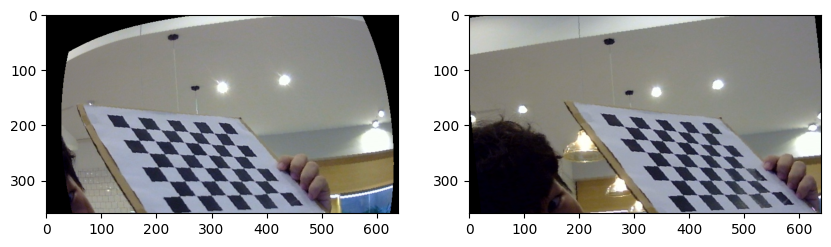

In [8]:
rows = 6
columns = 8
square_size = 2.5

image_size = (640, 360)

calibrator = StereoCalibrator(rows, columns, square_size, image_size)
print('Start cycle')

img_count = len([name for name in os.listdir('calibration/left') if os.path.isfile(os.path.join('calibration/left', name))])
for index in range(1, img_count + 1):
    print(f'Importing pair: {index}')
    leftName = f'calibration/left/{index}.jpg'
    rightName = f'calibration/right/{index}.jpg'
    if os.path.isfile(leftName) and os.path.isfile(rightName):
        #reading the images in Color
        imgLeft = cv2.imread(leftName, 1)
        imgRight = cv2.imread(rightName, 1)

        #Ensuring both left and right images have the same dimensions
        (H, W, C) = imgLeft.shape

        imgRight = cv2.resize(imgRight, (W, H))

        # Calibrating the camera (getting the corners and drawing them)
        try:
            calibrator._get_corners(imgLeft)
            calibrator._get_corners(imgRight)
        except ChessboardNotFoundError as error:
            print(error)
            print("Pair No " + str(index) + " ignored")
        else:
            calibrator.add_corners((imgLeft, imgRight))

    else:
        print ("Pair not found")
        continue


print('Cycle Complete!')

print('Starting calibration... It can take several minutes!')
calibration = calibrator.calibrate_cameras()
calibration.export('calib_result')
print('Calibration complete!')

# Lets rectify and show last pair after  calibration
calibration = StereoCalibration(input_folder='calib_result')
rectified_pair = calibration.rectify((imgLeft, imgRight))

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(rectified_pair[0][:, :, ::-1])
plt.subplot(1, 2, 2)
plt.imshow(rectified_pair[1][:, :, ::-1])

## Depth Map

In [46]:
def stereo_depth_map(rectified_pair, variable_mapping):
    '''print ('SWS='+str(SWS)+' PFS='+str(PFS)+' PFC='+str(PFC)+' MDS='+\
           str(MDS)+' NOD='+str(NOD)+' TTH='+str(TTH))
    print (' UR='+str(UR)+' SR='+str(SR)+' SPWS='+str(SPWS))'''

    # blockSize is the SAD Window Size
    # Filter settings
    sbm = cv2.StereoBM_create(
        numDisparities=16, blockSize=variable_mapping["SWS"])
    sbm.setPreFilterType(1)
    sbm.setPreFilterSize(variable_mapping['PreFiltSize'])
    sbm.setPreFilterCap(variable_mapping['PreFiltCap'])
    sbm.setSpeckleRange(variable_mapping['SpeckleRange'])
    sbm.setSpeckleWindowSize(variable_mapping['SpeckleSize'])
    sbm.setMinDisparity(variable_mapping['MinDisp'])
    sbm.setNumDisparities(variable_mapping['NumofDisp'])
    sbm.setTextureThreshold(variable_mapping['TxtrThrshld'])
    sbm.setUniquenessRatio(variable_mapping['UniqRatio'])

    c, r = rectified_pair[0].shape
    dmLeft = rectified_pair[0]
    dmRight = rectified_pair[1]

    sigma = 0.8
    lmbda = 7000
    left_disparity = sbm.compute(dmLeft, dmRight)
    right_disparity = sbm.compute(dmRight, dmLeft)

    wls_filter = cv2.ximgproc.createDisparityWLSFilter(sbm)
    wls_filter.setLambda(lmbda)
    wls_filter.setSigmaColor(sigma)
    filtered_disp = wls_filter.filter(
        left_disparity, dmLeft, disparity_map_right=right_disparity)

    disparity_normalized = cv2.normalize(
        left_disparity, None, 0, 255, cv2.NORM_MINMAX)
    # Convering Numpy Array to CV_8UC1
    image = np.array(disparity_normalized, dtype=np.uint8)
    disparity_color = cv2.applyColorMap(image, cv2.COLORMAP_JET)
    return disparity_color, disparity_normalized

In [10]:
def save_load_map_settings(current_save, current_load, variable_mapping):
    global loading
    if current_save != 0:
        print('Saving to file...')

        result = json.dumps({'SADWindowSize':variable_mapping["SWS"], 'preFilterSize':variable_mapping['PreFiltSize'], 'preFilterCap':variable_mapping['PreFiltCap'],
                'minDisparity':variable_mapping['MinDisp'], 'numberOfDisparities': variable_mapping['NumofDisp'], 'textureThreshold':variable_mapping['TxtrThrshld'],
                'uniquenessRatio':variable_mapping['UniqRatio'], 'speckleRange':variable_mapping['SpeckleRange'], 'speckleWindowSize':variable_mapping['SpeckleSize']},
                sort_keys=True, indent=4, separators=(',',':'))
        fName = '../3dmap_set.txt'
        f = open (str(fName), 'w')
        f.write(result)
        f.close()
        print ('Settings saved to file '+fName)


    if current_load != 0:
        if os.path.isfile('../3dmap_set.txt') == True:
            loading = True
            fName = '../3dmap_set.txt'
            print('Loading parameters from file...')
            f=open(fName, 'r')
            data = json.load(f)

            cv2.setTrackbarPos("SWS", "Stereo", data['SADWindowSize'])
            cv2.setTrackbarPos("PreFiltSize", "Stereo", data['preFilterSize'])
            cv2.setTrackbarPos("PreFiltCap", "Stereo", data['preFilterCap'])
            cv2.setTrackbarPos("MinDisp", "Stereo", data['minDisparity']+100)
            cv2.setTrackbarPos("NumofDisp", "Stereo", int(data['numberOfDisparities']/16))
            cv2.setTrackbarPos("TxtrThrshld", "Stereo", data['textureThreshold'])
            cv2.setTrackbarPos("UniqRatio", "Stereo", data['uniquenessRatio'])
            cv2.setTrackbarPos("SpeckleRange", "Stereo", data['speckleRange'])
            cv2.setTrackbarPos("SpeckleSize", "Stereo", data['speckleWindowSize'])

            f.close()
            print ('Parameters loaded from file '+fName)
            print ('Redrawing depth map with loaded parameters...')
            print ('Done!')

        else:
            print ("File to load from doesn't exist.")

In [11]:
def activateTrackbars(x):
    global loading
    loading = False

In [39]:
def create_trackbars() :
    global loading

    #SWS cannot be larger than the image width and image heights.
    #In this case, width = 320 and height = 240
    cv2.createTrackbar("SWS", "Stereo", 115, 230, activateTrackbars)
    cv2.createTrackbar("SpeckleSize", "Stereo", 0, 300, activateTrackbars)
    cv2.createTrackbar("SpeckleRange", "Stereo", 0, 40, activateTrackbars)
    cv2.createTrackbar("UniqRatio", "Stereo", 1, 20, activateTrackbars)
    cv2.createTrackbar("TxtrThrshld", "Stereo", 0, 1000, activateTrackbars)
    cv2.createTrackbar("NumofDisp", "Stereo", 1, 16, activateTrackbars)
    cv2.createTrackbar("MinDisp", "Stereo", -100, 200, activateTrackbars)
    cv2.createTrackbar("PreFiltCap", "Stereo", 1, 63, activateTrackbars)
    cv2.createTrackbar("PreFiltSize", "Stereo", 5, 255, activateTrackbars)
    cv2.createTrackbar("Save Settings", "Stereo", 0, 1, activateTrackbars)
    cv2.createTrackbar("Load Settings","Stereo", 0, 1, activateTrackbars)

In [13]:
def onMouse(event, x, y, flag, disparity_normalized):
    if event == cv2.EVENT_LBUTTONDOWN:
        distance = disparity_normalized[y][x]
        print("Distance in centimeters {}".format(distance))

### Capture video

In [15]:
VIDEO_PATH = "video"
removeFolderContent(VIDEO_PATH)

In [16]:
frame_width = int(cam1.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cam1.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = 20.0

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out1 = cv2.VideoWriter(f'{VIDEO_PATH}/left.avi', fourcc, fps, (frame_width, frame_height))
out2 = cv2.VideoWriter(f'{VIDEO_PATH}/right.avi', fourcc, fps, (frame_width, frame_height))

while True:
    ret1, frame1 = cam1.read()
    ret2, frame2 = cam2.read()

    if ret1 and ret2:
        out1.write(frame1)
        out2.write(frame2)

        cv2.imshow('Left Camera', frame1)
        cv2.imshow('Right Camera', frame2)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        print("Failed to grab frames.")
        break

out1.release()
out2.release()
cv2.destroyAllWindows()

### Compute Death

In [ ]:
cv2.namedWindow("Stereo")
create_trackbars()
variables = ["SWS", "SpeckleSize", "SpeckleRange", "UniqRatio", "TxtrThrshld", "NumofDisp",
             "MinDisp", "PreFiltCap", "PreFiltSize"]
variable_mapping = {"SWS": 15, "SpeckleSize": 100, "SpeckleRange": 15, "UniqRatio": 10, "TxtrThrshld": 100, "NumofDisp": 1,
                    "MinDisp": -25, "PreFiltCap": 30, "PreFiltSize": 105}

video_left = cv2.VideoCapture("video/left.avi")
video_right = cv2.VideoCapture("video/right.avi")
while True:
    left_grabbed, left_frame = video_left.read()
    right_grabbed, right_frame = video_right.read()

    if not left_grabbed or not right_grabbed:
        break

    left_gray_frame = cv2.cvtColor(left_frame, cv2.COLOR_BGR2GRAY)
    right_gray_frame = cv2.cvtColor(right_frame, cv2.COLOR_BGR2GRAY)

    calibration = StereoCalibration(input_folder='calib_result')
    rectified_pair = calibration.rectify((left_gray_frame, right_gray_frame))

    #getting trackbar position and assigning to the variables
    if loading == False:
        for v in variables:
            current_value = cv2.getTrackbarPos(v, "Stereo")
            if v == "SWS" or v == "PreFiltSize":
                if current_value < 5:
                    current_value = 5
                if current_value % 2 == 0:
                    current_value += 1

            if v == "NumofDisp":
                if current_value == 0:
                    current_value = 1
                current_value = current_value * 16
            if v == "MinDisp":
                current_value = current_value - 100
            if v == "UniqRatio" or v == "PreFiltCap":
                if current_value == 0:
                    current_value = 1

            variable_mapping[v] = current_value



    #getting save and load trackbar positions

    current_save = cv2.getTrackbarPos("Save Settings", "Stereo")
    current_load = cv2.getTrackbarPos("Load Settings", "Stereo")

    save_load_map_settings(current_save, current_load, variable_mapping)
    cv2.setTrackbarPos("Save Settings", "Stereo", 0)
    cv2.setTrackbarPos("Load Settings", "Stereo", 0)
    disparity_color, disparity_normalized = stereo_depth_map(rectified_pair, variable_mapping)

    #What happens when the mouse is clicked
    cv2.setMouseCallback("Stereo", onMouse, disparity_normalized)

    cv2.imshow("Stereo", disparity_color)
    cv2.imshow("Frame", np.hstack((rectified_pair[0], rectified_pair[1])))
    time.sleep(100/1000)

    k = cv2.waitKey(1) & 0xFF
    if k == ord('q'):
        break

    else:
        continue

video_left.release()
video_right.release()
cv2.destroyAllWindows()

Loading parameters from file...
Parameters loaded from file ../3dmap_set.txt
Redrawing depth map with loaded parameters...
Done!
Saving to file...
Settings saved to file ../3dmap_set.txt


## Distance detection

In [44]:
# Depth map default preset
SWS = 5
PFS = 5
PFC = 29
MDS = -30
NOD = 160
TTH = 100
UR = 10
SR = 14
SPWS = 100


def load_map_settings(file):
    global SWS, PFS, PFC, MDS, NOD, TTH, UR, SR, SPWS, loading_settings, sbm
    print('Loading parameters from file...')
    f = open(file, 'r')
    data = json.load(f)
    #loading data from the json file and assigning it to the Variables
    SWS = data['SADWindowSize']
    PFS = data['preFilterSize']
    PFC = data['preFilterCap']
    MDS = data['minDisparity']
    NOD = data['numberOfDisparities']
    TTH = data['textureThreshold']
    UR = data['uniquenessRatio']
    SR = data['speckleRange']
    SPWS = data['speckleWindowSize']

    #changing the actual values of the variables
    sbm = cv2.StereoBM_create(numDisparities=16, blockSize=SWS)
    sbm.setPreFilterType(1)
    sbm.setPreFilterSize(PFS)
    sbm.setPreFilterCap(PFC)
    sbm.setMinDisparity(MDS)
    sbm.setNumDisparities(NOD)
    sbm.setTextureThreshold(TTH)
    sbm.setUniquenessRatio(UR)
    sbm.setSpeckleRange(SR)
    sbm.setSpeckleWindowSize(SPWS)
    f.close()
    print('Parameters loaded from file ' + file)

In [26]:
def stereo_depth_map1(rectified_pair):
    #blockSize is the SAD Window Size

    dmLeft = rectified_pair[0]
    dmRight = rectified_pair[1]
    disparity = sbm.compute(dmLeft, dmRight)
    disparity_normalized = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX)
    image = np.array(disparity_normalized, dtype = np.uint8)
    disparity_color = cv2.applyColorMap(image, cv2.COLORMAP_JET)
    return disparity_color, disparity_normalized

In [45]:
load_map_settings("../3dmap_set.txt")

cv2.namedWindow("DepthMap")

while True:
    left_grabbed, left_frame = cam1.read()
    right_grabbed, right_frame = cam2.read()

    if left_grabbed and right_grabbed:
        # Convert BGR to Grayscale for calibration
        left_gray_frame = cv2.cvtColor(left_frame, cv2.COLOR_BGR2GRAY)
        right_gray_frame = cv2.cvtColor(right_frame, cv2.COLOR_BGR2GRAY)

        # Call calibration results and rectify the images
        calibration = StereoCalibration(input_folder='calib_result')
        rectified_pair = calibration.rectify((left_gray_frame, right_gray_frame))
        disparity_color, disparity_normalized = stereo_depth_map1(rectified_pair)

        # Set mouse callback on the "DepthMap" window
        cv2.setMouseCallback("DepthMap", onMouse, disparity_normalized)

        # Resize disparity_color if necessary to match left_frame size
        height, width = left_frame.shape[:2]
        disparity_color_resized = cv2.resize(disparity_color, (width, height))

        # Ensure disparity_color has 3 channels
        if len(disparity_color_resized.shape) == 2 or disparity_color_resized.shape[2] == 1:
            disparity_color_bgr = cv2.cvtColor(disparity_color_resized, cv2.COLOR_GRAY2BGR)
        else:
            disparity_color_bgr = disparity_color_resized

        # Blend left_frame and disparity_color_bgr
        output = cv2.addWeighted(left_frame, 0.5, disparity_color_bgr, 0.5, 0.0)

        # Display the depth map and frames side-by-side
        cv2.imshow("DepthMap", np.hstack((disparity_color_bgr, output)))
        cv2.imshow("Frames", np.hstack((left_frame, right_frame)))

        k = cv2.waitKey(1) & 0xFF
        if k == ord('q'):
            break
        else:
            continue

cv2.destroyAllWindows()

Loading parameters from file...
Parameters loaded from file ../3dmap_set.txt
